# Solving eigenvalue problem using physics-informed neural networks

---

*Jingtao Min @ ETH Zürich 2023*

In [31]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import matplotlib.pyplot as plt
from physics_nn import pinn_eigen

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1-D eigenvalue problem of real scalar field: standing wave solution in bounded domain

The classical textbook eigenvalue problem is described by the following Sturm-Liouville problem

$$
\left\{\begin{aligned}
&\frac{\partial^2 u}{\partial x^2} = \lambda u,\quad x \in (0, 1) \\
&u|_{x=0,1} = 0
\end{aligned}\right.
$$

which has eigenvalues and eigenfunctions

$$
\lambda_k = (k\pi)^2,\quad u_k = \sin k\pi x,\quad k \in \mathbb{N} \quad \Longrightarrow \quad \hat{u}_k = \sqrt{2} \sin k\pi x.
$$

The latter $\hat{u}$ is the eigenfunction with normalized norm, i.e. $\int \hat{u}_k^2 dx = 1$.

For an eigenvalue problem, it is almost never enough to just implement the PDE constraint and the boundary constraints (i.e. penalizing the PDE residual and the boundary discrepancies). The reason is that the linear eigenvalue problem, most commonly with homogeneous boundary conditions, will always have trivial solutions. Without additional constraints, the neural network will be attracted towards a zero eigenfunction, which is definitely a global minimum (with zero loss), with some arbitrary (but probably very small as well) eigenvalues.

There are two approaches to tackle this problem:
- Add additional interior point constraint to force the value at an interior point to some non-trivial value; this can be implemented with the boundary conditions.
- Enforce normalization of the eigenfunction. This will be my approach here, as it is more generally applicable.

---

### Eigenfunction solver

The following code attempts to solve the eigenfunction, when the eigenvalue is given or estimated using other methods (e.g. Rayleigh-Ritz, etc).

The eigenfunction is approximated by the neural network as $\hat{f}(x; \theta)$, where $\theta$ denotes the neural network parameters.
The loss function contains three terms:

$$
\begin{aligned}
L(\theta; D, \lambda_\mathrm{BC}, \lambda_\mathrm{mag}) &= L_{\mathrm{PDE}}(\theta; D) + \lambda_\mathrm{BC} L_\mathrm{BC}(\theta) + \lambda_\mathrm{mag} L_\mathrm{mag}(\theta; D) \\
&= \sum_{x_i\in D} \left(\mathcal{L} \hat{f}(x_i; \theta)\right)^2 + \lambda_\mathrm{BC} \sum_{x_i\in \{0, 1\}}\left(\hat{f}(x_i; \theta)\right)^2 + \lambda_\mathrm{mag} \left(\sum_{x_i \in D} w_i\hat{f}^2(x_i;\theta) - 1\right)^2
\end{aligned}
$$

where $D$ denotes the dataset of interior points. Here all of the misfits and regularizations are measured in $L^2$ norm, but this can well be adjusted (although I am not sure whether auto-differentiation can work properly on non-differentiable norms, such as $L^1$)


In [34]:
class Eigen_Standing_Wave_1D(pinn_eigen.EigenFuncNN1D):
    
    def __init__(self, forward_approx, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.approximator = forward_approx
    
    def forward(self, x_input):
        return self.approximator(self.normalize(x_input))
    
    def residual(self, x_int):
        x_int.requires_grad = True
        u_int = self.forward(x_int)
        du_dx = torch.autograd.grad(u_int.sum(), x_int, create_graph=True)[0]
        d2u_dx2 = torch.autograd.grad(du_dx.sum(), x_int, create_graph=True)[0]
        res = d2u_dx2 - self.eigval*u_int
        return torch.mean(torch.abs(res)**2)

Setup the system.
- Architecture: Multi-layer perceptron with 2 hidden layers, 20 neurons in each layer
- Initialization: Xavier initialization on linear layers
- Optimization: Adaptive moment optimizer (Adam)

The eigenvalue is

$$
\lambda_k = -(k\pi)^2
$$

In [93]:
torch.manual_seed(42)

nn_approx = pinn_eigen.uniform_MLP(in_dim=1, out_dim=1, neurons=20, n_hidden_layers=2)
nn_approx.apply(pinn_eigen.linear_init_xavier)

k_true = 4.
eigval_true = -(k_true*np.pi)**2

eigen_nn = Eigen_Standing_Wave_1D(nn_approx, eigval_true, x_range=torch.tensor([[0, 1]]), bc_weight=1.5e+4, mag_weight=1e+4)
optim_adam = torch.optim.Adam(nn_approx.parameters(), lr=1.e-3, weight_decay=2e-5)

Training

--------------- Epoch 200 ---------------
Average training loss = 3.993260
--------------- Epoch 400 ---------------
Average training loss = 3.550313
--------------- Epoch 600 ---------------
Average training loss = 2.134671
--------------- Epoch 800 ---------------
Average training loss = 1.695115
--------------- Epoch 1000 ---------------
Average training loss = 1.381414
--------------- Epoch 1200 ---------------
Average training loss = 1.620304
--------------- Epoch 1400 ---------------
Average training loss = 1.499436
--------------- Epoch 1600 ---------------
Average training loss = 1.325718
--------------- Epoch 1800 ---------------
Average training loss = 1.543336
--------------- Epoch 2000 ---------------
Average training loss = 1.721407


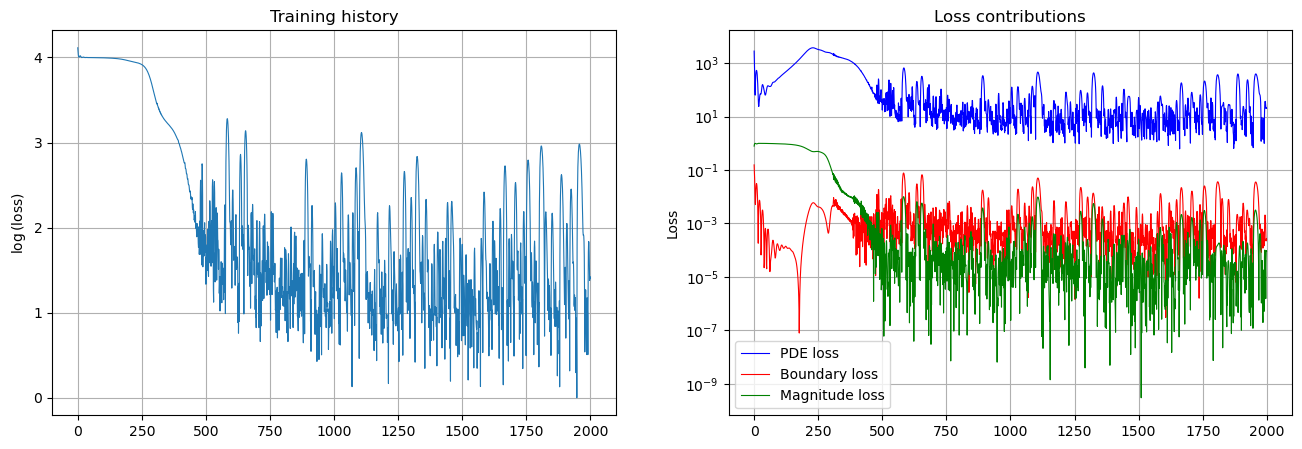

In [94]:
n_epochs = 2000
verbose_epochs = 200
train_log = list()
pde_log = list()
bc_log = list()
mag_log = list()
for epoch in range(n_epochs):
    optim_adam.zero_grad()
    loss = eigen_nn.compute_loss()
    loss[0].backward()
    optim_adam.step()
    train_log.append(loss[0].detach().item())
    pde_log.append(loss[1].detach().item())
    bc_log.append(loss[2].detach().item())
    mag_log.append(loss[3].detach().item())
    if (epoch + 1)%verbose_epochs == 0:
        print("--------------- Epoch {:d} ---------------".format(epoch + 1))
        print("Average training loss = {:f}".format(np.array(train_log[-verbose_epochs:]).mean()))


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

ax = axes[0]
ax.plot(train_log, linewidth=.8)
ax.grid(which="both")
ax.set_ylabel(r"$\log$(loss)")
ax.set_title("Training history")

ax = axes[1]
ax.semilogy(pde_log, 'b-', label="PDE loss", linewidth=.8)
ax.semilogy(bc_log, 'r-', label="Boundary loss", linewidth=.8)
ax.semilogy(mag_log, 'g-', label="Magnitude loss", linewidth=.8)
ax.grid(which="major")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("Loss contributions")

plt.show()

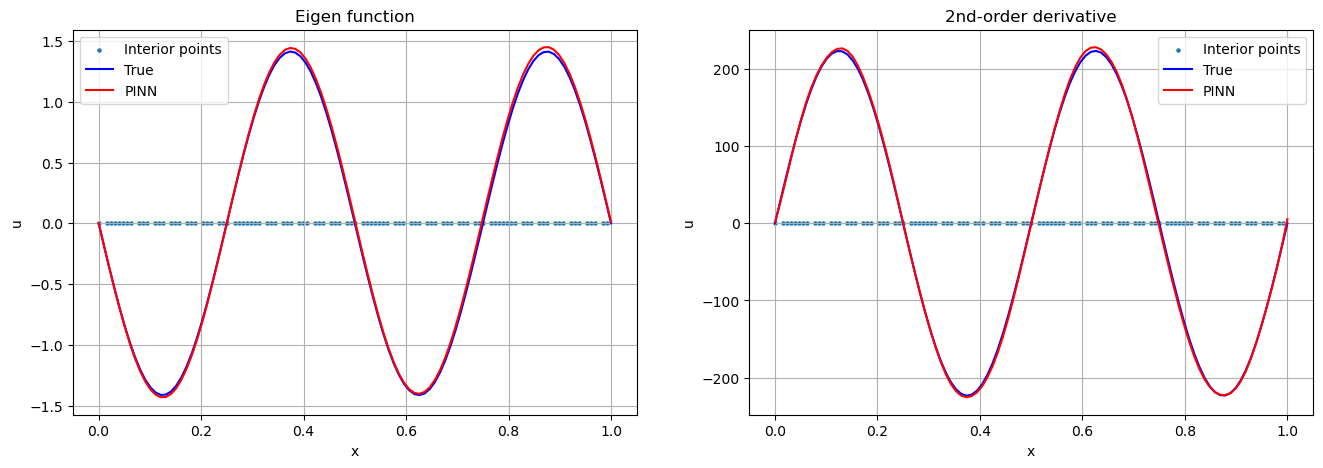

In [95]:
x_array = torch.atleast_2d(torch.linspace(0, 1, 100)).T
x_array.requires_grad = True
u_pred = eigen_nn.forward(x_array)
du_dx_pred = torch.autograd.grad(u_pred.sum(), x_array, create_graph=True)[0]
d2u_dx2_pred = torch.autograd.grad(du_dx_pred.sum(), x_array)[0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

ax = axes[0]
ax.scatter(eigen_nn.train_pt_int.detach().numpy(), np.zeros(100), 5, label="Interior points")
ax.plot(x_array.detach().numpy(), -np.sqrt(2)*np.sin(k_true*np.pi*np.linspace(0, 1, num=100)), 'b-', label="True")
ax.plot(x_array.detach().numpy(), u_pred.detach().numpy(), 'r-', label="PINN")
ax.grid(which="both")
ax.set_xlabel("x")
ax.set_ylabel("u")
ax.legend()
ax.set_title("Eigen function")

ax = axes[1]
ax.scatter(eigen_nn.train_pt_int.detach().numpy(), np.zeros(100), 5, label="Interior points")
ax.plot(x_array.detach().numpy(), -np.sqrt(2)*eigval_true*np.sin(k_true*np.pi*np.linspace(0, 1, num=100)), 'b-', label="True")
ax.plot(x_array.detach().numpy(), d2u_dx2_pred.detach().numpy(), 'r-', label="PINN")
ax.grid(which="both")
ax.set_xlabel("x")
ax.set_ylabel("u")
ax.legend()
ax.set_title("2nd-order derivative")

plt.show()

## Archive code

In [29]:
def linear_init_xavier(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=torch.nn.init.calculate_gain("tanh"))

class EigenNN1D:
    
    def __init__(self, eigval, n_int=100, bc_weight=1., mag_weight=1.) -> None:
        
        self.eigval = eigval
        self.n_int = n_int
        self.bc_weight = bc_weight
        self.mag_weight = mag_weight
        self.x_range = torch.tensor([[0, 1]])
        self.jac = (self.x_range[0, 1] - self.x_range[0, 0])/2

        torch.manual_seed(42)
        self.approximator = torch.nn.Sequential(
            torch.nn.Linear(1, 20), torch.nn.Tanh(),
            torch.nn.Linear(20, 20), torch.nn.Tanh(),
            torch.nn.Linear(20, 20), torch.nn.Tanh(),
            torch.nn.Linear(20, 1)
        )
        
        self.approximator.apply(linear_init_xavier)
        self.sobol_engine = torch.quasirandom.SobolEngine(dimension=self.x_range.shape[0])
        self.train_pt_int = self.sobol_to_physics_dom(self.sobol_engine.draw(self.n_int))
    
    def sobol_to_physics_dom(self, sobol_samples):
        physics_samples = sobol_samples*(self.x_range[0, 1] - self.x_range[0, 0]) + self.x_range[0, 0]
        return physics_samples
    
    def normalize(self, x_input):
        x_normalized = (x_input - self.x_range[0, 0])/self.jac - 1
        return x_normalized
    
    def denormalize(self, x_input):
        x_denormalized = (x_input + 1)*self.jac + self.x_range[0, 0]
        return x_denormalized
    
    def forward(self, x_input):
        return self.approximator(self.normalize(x_input))
        
    def residual(self, x_int):
        x_int.requires_grad = True
        u_int = self.forward(x_int)
        du_dx = torch.autograd.grad(u_int.sum(), x_int, create_graph=True)[0]
        d2u_dx2 = torch.autograd.grad(du_dx.sum(), x_int, create_graph=True)[0]
        res = d2u_dx2 - self.eigval*u_int
        return res.reshape(-1, )
    
    def boundary_loss(self):
        val_bc = self.forward(torch.tensor([[0.], [1.]]))
        val_train = torch.tensor([[0.], [0.]])
        loss_bc = torch.mean(torch.abs(val_bc - val_train)**2)
        return loss_bc
    
    def magnitude_loss(self):
        modulus_squared = torch.mean(self.forward(self.train_pt_int)**2)
        return (modulus_squared - 1.)**2
    
    def compute_loss(self, x_int):
        res = self.residual(x_int)
        loss_int = torch.mean(torch.abs(res)**2)
        loss_bc = self.boundary_loss()
        loss_mod = self.magnitude_loss()
        loss = loss_int + self.bc_weight*loss_bc + self.mag_weight*loss_mod
        return torch.log10(loss), loss_int, loss_bc, loss_mod
    
    def predict(self, x_int):
        self.approximator.eval()
        return self.approximator(self.normalize(x_int))
    

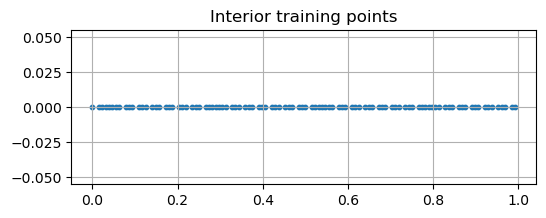

tensor([-0.4607, -0.1173, -0.4062,  0.6634, -0.7894, -0.4610, -0.2824, -0.6013,
         0.0944, -0.9877,  0.9031, -0.8495,  0.7720,  0.1664, -0.3247,  0.6179,
         0.1559,  0.8080,  0.1093, -0.3154], grad_fn=<SqueezeBackward0>)
--------------- Epoch 100 ---------------
Average training loss = 3.868991
--------------- Epoch 200 ---------------
Average training loss = 3.730946
--------------- Epoch 300 ---------------
Average training loss = 3.427887
--------------- Epoch 400 ---------------
Average training loss = 3.027499
--------------- Epoch 500 ---------------
Average training loss = 2.384116
--------------- Epoch 600 ---------------
Average training loss = 1.797146
--------------- Epoch 700 ---------------
Average training loss = 1.890654
--------------- Epoch 800 ---------------
Average training loss = 1.797988
--------------- Epoch 900 ---------------
Average training loss = 1.659470
--------------- Epoch 1000 ---------------
Average training loss = 1.319412
--------------- 

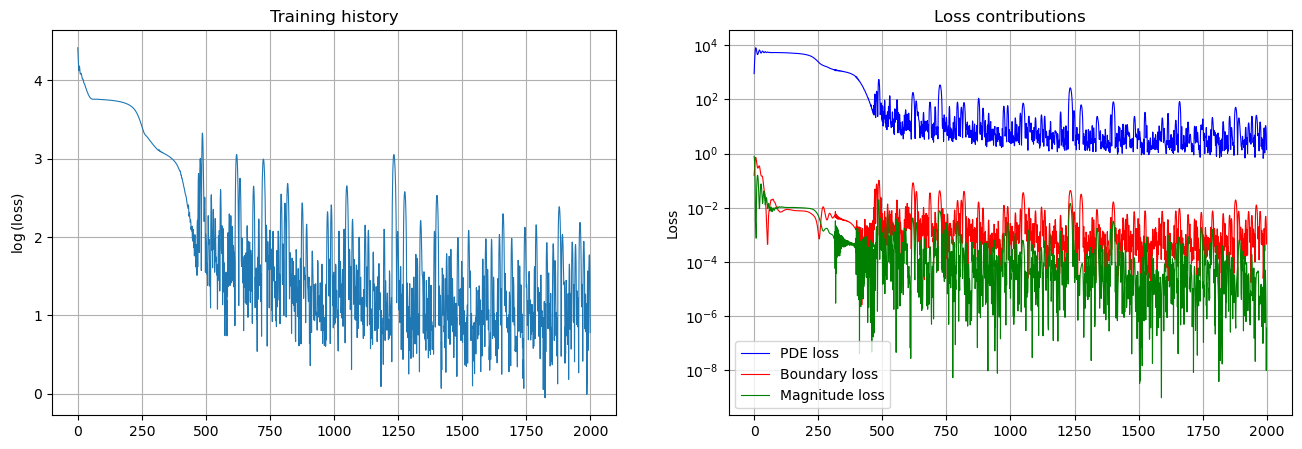

In [30]:
k_true = 3.
eigval_true = -(k_true*np.pi)**2
eigen_nn = EigenNN1D(eigval_true, bc_weight=1e+4, mag_weight=3e+4)
optim_adam = torch.optim.Adam(eigen_nn.approximator.parameters(), lr=1e-3, weight_decay=1e-4)

fig = plt.figure(figsize=(6, 2))
plt.scatter(eigen_nn.train_pt_int.detach().numpy(), np.zeros(100), 10)
plt.grid()
plt.title("Interior training points")
plt.show()
print(eigen_nn.approximator[0].bias.squeeze())

n_epochs = 2000
verbose_epochs = 100
train_log = list()
pde_log = list()
bc_log = list()
mag_log = list()
for epoch in range(n_epochs):
    optim_adam.zero_grad()
    loss = eigen_nn.compute_loss(eigen_nn.train_pt_int)
    loss[0].backward()
    optim_adam.step()
    train_log.append(loss[0].detach().item())
    pde_log.append(loss[1].detach().item())
    bc_log.append(loss[2].detach().item())
    mag_log.append(loss[3].detach().item())
    if (epoch + 1)%verbose_epochs == 0:
        print("--------------- Epoch {:d} ---------------".format(epoch + 1))
        print("Average training loss = {:f}".format(np.array(train_log[-verbose_epochs:]).mean()))


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

ax = axes[0]
ax.plot(train_log, linewidth=.8)
ax.grid(which="both")
ax.set_ylabel(r"$\log$(loss)")
ax.set_title("Training history")

ax = axes[1]
ax.semilogy(pde_log, 'b-', label="PDE loss", linewidth=.8)
ax.semilogy(bc_log, 'r-', label="Boundary loss", linewidth=.8)
ax.semilogy(mag_log, 'g-', label="Magnitude loss", linewidth=.8)
ax.grid(which="major")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("Loss contributions")

plt.show()

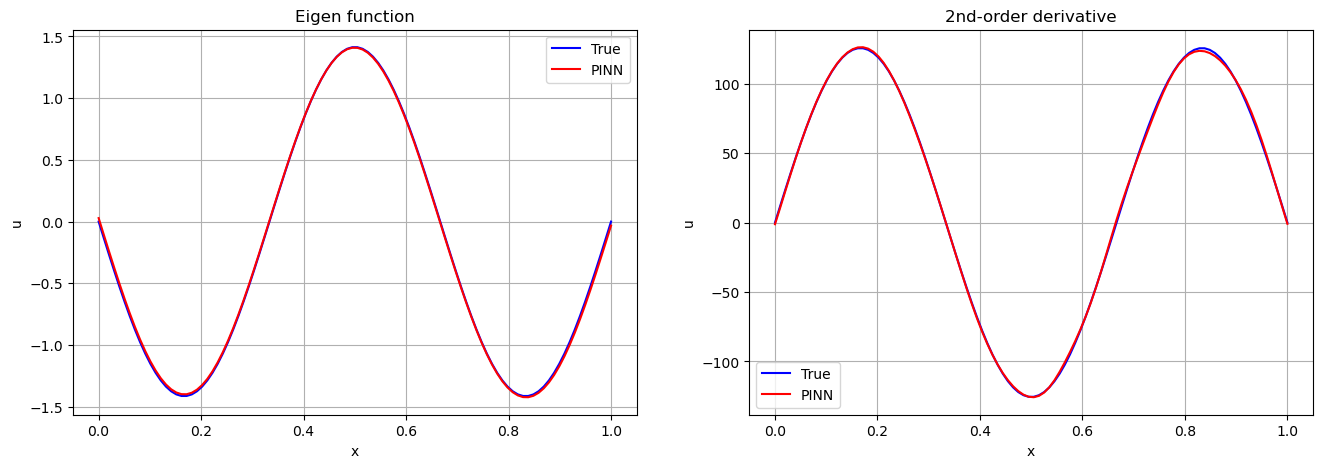

In [17]:
x_array = torch.atleast_2d(torch.linspace(0, 1, 100)).T
# u_pred = eigen_nn.predict(x_array).detach().numpy()
x_array.requires_grad = True
u_pred = eigen_nn.forward(x_array)
du_dx_pred = torch.autograd.grad(u_pred.sum(), x_array, create_graph=True)[0]
d2u_dx2_pred = torch.autograd.grad(du_dx_pred.sum(), x_array)[0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

ax = axes[0]
ax.plot(x_array.detach().numpy(), -np.sqrt(2)*np.sin(k_true*np.pi*np.linspace(0, 1, num=100)), 'b-', label="True")
ax.plot(x_array.detach().numpy(), u_pred.detach().numpy(), 'r-', label="PINN")
ax.grid(which="both")
ax.set_xlabel("x")
ax.set_ylabel("u")
ax.legend()
ax.set_title("Eigen function")

ax = axes[1]
ax.plot(x_array.detach().numpy(), -np.sqrt(2)*eigval_true*np.sin(k_true*np.pi*np.linspace(0, 1, num=100)), 'b-', label="True")
ax.plot(x_array.detach().numpy(), d2u_dx2_pred.detach().numpy(), 'r-', label="PINN")
ax.grid(which="both")
ax.set_xlabel("x")
ax.set_ylabel("u")
ax.legend()
ax.set_title("2nd-order derivative")

plt.show()